# Modelling with Time Series
#### *use the `sktime` conda environment*

### Contents:
 - [Import for Time Series Models](#Import-for-Time-Series-Models)
 - [Set X and y and TTS](#Set-X-and-y-and-TTS)
 - [Model by Months](#Model-by-Months)
   - [SARIMAX by Months](#SARIMAX-by-Months)
   - [Holt-Winters by Months](#Holt-Winters-by-Months)
 - [Plot Time Series and Compare](#Plot-Time-Series-and-Compare)
 - [Save Model](#Save-Model)


## Import for Time Series Models
[(back to top)](#Modelling-with-Time-Series)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
import statsmodels
import sktime

import pmdarima as pmd
from pmdarima.utils import tsdisplay

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import EnsembleForecaster

import pickle
import warnings
warnings.simplefilter('ignore')

In [4]:
df = pd.read_csv('../data/elec_mo_2001_2011_consumption.csv')

In [5]:
df.columns

Index(['date', 'STATE', 'CONSUMPTION'], dtype='object')

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.set_index('date', inplace=True)

In [8]:
df.shape

(6864, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6864 entries, 2001-01-01 to 2011-12-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATE        6864 non-null   object 
 1   CONSUMPTION  6864 non-null   float64
dtypes: float64(1), object(1)
memory usage: 160.9+ KB


In [10]:
df_nc = df[df['STATE'] == 'NC']

## Set X and y and TTS
[(back to top)](#Modelling-with-Time-Series)

In [11]:
X = df_nc.drop(columns=['CONSUMPTION'])
y = df_nc['CONSUMPTION']

In [12]:
X_train = X[X.index.year < 2010]
X_test = X[X.index.year >= 2010]
y_train = y[y.index.year < 2010]
y_test = y[y.index.year >= 2010]

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108, 1)
(24, 1)
(108,)
(24,)


In [14]:
24/(108+24)

0.18181818181818182

In [15]:
preds_df = df_nc.copy(deep=True)
preds_df = preds_df[['CONSUMPTION']]
preds_df = preds_df[preds_df.index.year >= 2010]
preds_df

,CONSUMPTION
date,
2010-01-01,7644722.0
2010-02-01,5789191.0
2010-03-01,4750359.0
2010-04-01,5037134.0
2010-05-01,8072468.0
2010-06-01,13899885.0
2010-07-01,14995985.0
2010-08-01,13264323.0
2010-09-01,8205139.0


In [16]:
train = df_nc.loc[:'2009']
test = df_nc.loc['2010':]

# Model by Months
[(back to top)](#Modelling-with-Time-Series)

## SARIMAX by Months
[(back to top)](#Modelling-with-Time-Series)

This appears "muted" with low peaks and shallow valleys, but scores best so far.

In [17]:
# model = pmd.auto_arima(y_train, m=364, trace=True)
sarimax_model = pmd.auto_arima(y_train.resample('M').max(), m=12, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3426.621, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3497.751, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3433.592, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3440.787, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3663.659, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=3436.516, Time=0.20 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=3425.821, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=3456.108, Time=0.05 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=3424.934, Time=1.22 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=3426.879, Time=1.19 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=3424.326, Time=0.98 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=3424.254, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=3456.462, Time=0.03 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=3425.978, Time=0.31 sec
 ARIMA(1,0,2)(0,0,1

In [18]:
sarimax_preds = sarimax_model.predict(24)
sarimax_preds

array([5261827.22752026, 4313703.91805824, 5056713.1562761 ,
       3841852.72956005, 4419415.37237245, 6013332.32414866,
       6681097.08194675, 8117900.98418843, 7360777.60363199,
       3908055.99087628, 4619564.02251938, 4903866.99102022,
       5212590.46350894, 4611647.96182915, 5089127.6736285 ,
       4354234.80874702, 4725066.01105333, 5578374.80622452,
       5989157.97550994, 6763675.09908472, 6366692.1543079 ,
       4404821.7986331 , 4825566.47775875, 4966203.51506155])

In [19]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood               -1706.127
Date:                             Mon, 24 May 2021   AIC                           3424.254
Time:                                     13:47:03   BIC                           3440.347
Sample:                                          0   HQIC                          3430.779
                                             - 108                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.177e+06   1.67e-08    2.5e+14      0.000    4.18e+06    4.18e+06
ar.L1         -0.8786      0.197     -4.455      0.000      -1.265      -0.492
ma.L1          1.3792      0.213      6.470      0.000       0.961       1.797
ma.L2          0.4827      0.152      3.167      0.002       0.184       0.781
ar.S.L12       0.5611      0.044     12.626      0.000       0.474       0.648
sigma2      4.157e+12   1.57e-14   2.64e+26      0.000    4.16e+12    4.16e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                67.23
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             1.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.4e+42. Standard errors may be unstable.
"""

In [20]:
print(f'MSE: {round(mse(y_test, sarimax_preds, squared=False), 0)}')
print(f'MAE: {round(mae(y_test, sarimax_preds), 0)}')

MSE: 4713245.0
MAE: 3813522.0


In [21]:
sarimax_df = pd.DataFrame(sarimax_preds)
sarimax_df.set_index(test.index, inplace=True)

In [22]:
preds_df['SARIMAX'] = sarimax_df[0]
preds_df.head(2)

,CONSUMPTION,SARIMAX
date,,
2010-01-01,7644722.0,5.261827e+06
2010-02-01,5789191.0,4.313704e+06


## Holt-Winters by Months
[(back to top)](#Modelling-with-Time-Series)


In [23]:
hw = ExponentialSmoothing(
    train['CONSUMPTION'],
    seasonal_periods=12,
    trend='mul',
    seasonal='add'
).fit()

In [24]:
hw_preds = hw.forecast(y_test.shape[0])

In [25]:
hw_df = pd.DataFrame(hw_preds)
hw_df.set_index(test.index, inplace=True)
hw_df.head(2)

,0
date,
2010-01-01,5.016905e+06
2010-02-01,4.306232e+06


In [26]:
preds_df['holt_winters'] = hw_df[0]
preds_df

,CONSUMPTION,SARIMAX,holt_winters
date,,,
2010-01-01,7644722.0,5.261827e+06,5.016905e+06
2010-02-01,5789191.0,4.313704e+06,4.306232e+06
2010-03-01,4750359.0,5.056713e+06,4.926005e+06
2010-04-01,5037134.0,3.841853e+06,4.937439e+06
2010-05-01,8072468.0,4.419415e+06,4.999638e+06
2010-06-01,13899885.0,6.013332e+06,7.096617e+06
2010-07-01,14995985.0,6.681097e+06,8.784995e+06
2010-08-01,13264323.0,8.117901e+06,1.142608e+07
2010-09-01,8205139.0,7.360778e+06,5.865920e+06


In [27]:
print(f'MSE: {round(mse(y_test, hw_preds, squared=False), 0)}')
print(f'MAE: {round(mae(y_test, hw_preds), 0)}')

MSE: 3631847.0
MAE: 2920368.0


## Plot Time Series and Compare
[(back to top)](#Modelling-with-Time-Series)

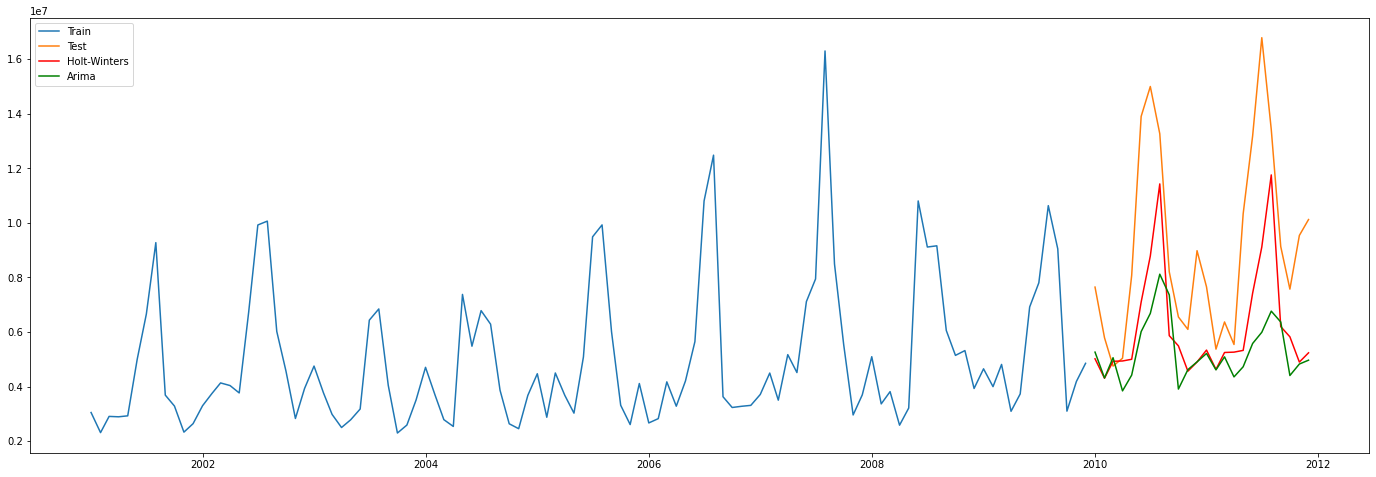

In [28]:
plt.figure(figsize=(24,8))
plt.plot(y_train, label='Train')
plt.plot(preds_df['CONSUMPTION'], label='Test')
plt.plot(preds_df['holt_winters'], label='Holt-Winters', color='red')
plt.plot(preds_df['SARIMAX'], label='Arima', color='green')
plt.legend(loc='best');

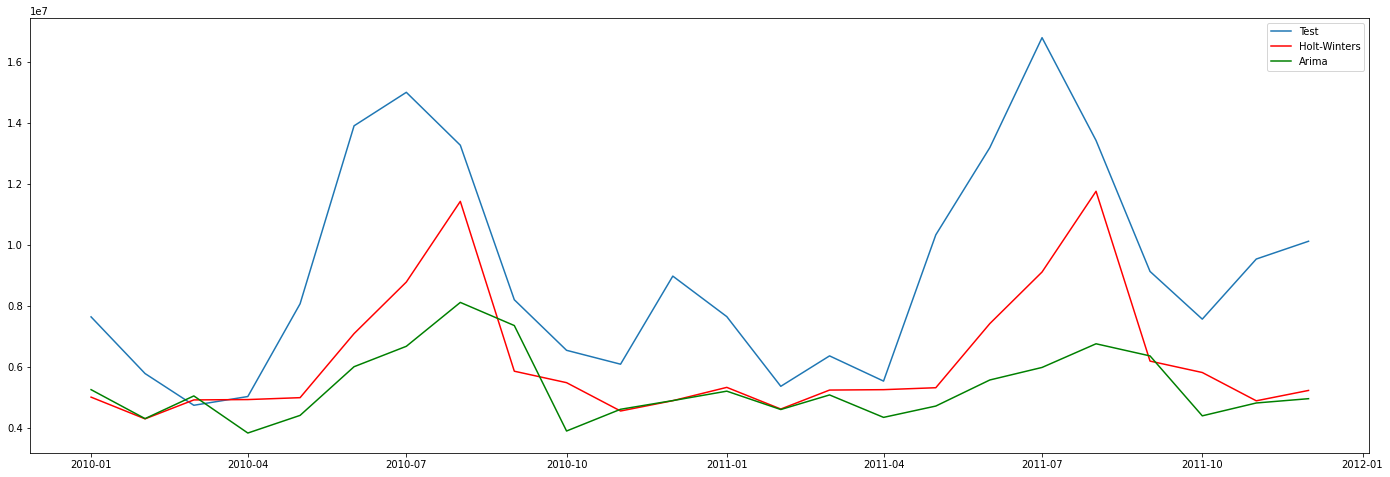

In [29]:
plt.figure(figsize=(24,8))
plt.plot(preds_df['CONSUMPTION'], label='Test')
plt.plot(preds_df['holt_winters'], label='Holt-Winters', color='red')
plt.plot(preds_df['SARIMAX'], label='Arima', color='green')
plt.legend(loc='best');

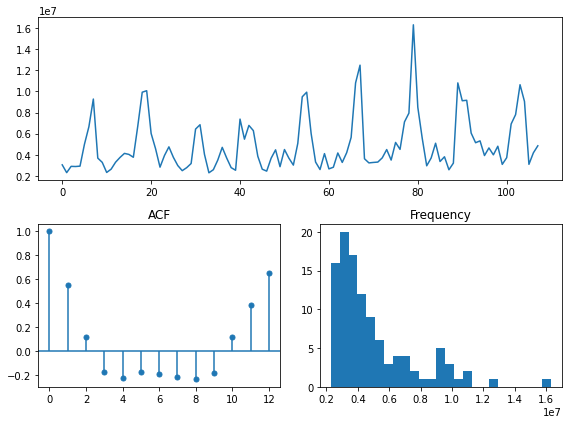

In [30]:
tsdisplay(y_train, lag_max=12)

### Save Model
[(back to top)](#Modelling-with-Time-Series)

In [31]:
# with open('timeseries_model_1.pkl', 'wb') as file:
#     pickle.dump(model, file)